# FaceNet (CNN)

FaceNet реализована 6 разными архитектырами нейронных сетей, здесь рассмотрена модель NN4 Small (an Inception model with 96x96 images as input). Рассмотри архитектуру сети. 

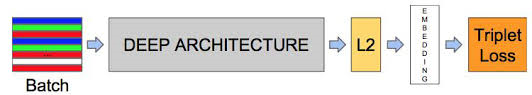

На вход поступает 96x96x3 изображение, а на выходе получаются вектор с размерностью 128. Подробно архитектура сетей разобрана в данной [статье](https://arxiv.org/pdf/1503.03832.pdf)  

**Примечание: последний слой нормализует венктор на d-мерную гиперсферу с расстоянием 1 от 0-вектора)**

In [1]:
from model import create_model
nn4_small2 = create_model()

Сама модель NN4 Small представлена в model.py, а графическое представление можно найти в model.png


In [2]:
nn4_small2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn1 (BatchNormalization)       (None, 48, 48, 64)   256         ['conv1[0][0]']                  
                                                                                              

 inception_3a_5x5_bn2 (BatchNor  (None, 12, 12, 32)  128         ['inception_3a_5x5_conv2[0][0]'] 
 malization)                                                                                      
                                                                                                  
 activation_7 (Activation)      (None, 5, 5, 32)     0           ['inception_3a_pool_bn[0][0]']   
                                                                                                  
 inception_3a_1x1_bn (BatchNorm  (None, 12, 12, 64)  256         ['inception_3a_1x1_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 activation_4 (Activation)      (None, 12, 12, 128)  0           ['inception_3a_3x3_bn2[0][0]']   
                                                                                                  
 activatio

                                                                  'zero_padding2d_9[0][0]',       
                                                                  'activation_14[0][0]']          
                                                                                                  
 inception_3c_3x3_conv1 (Conv2D  (None, 12, 12, 128)  41088      ['concatenate_1[0][0]']          
 )                                                                                                
                                                                                                  
 inception_3c_5x5_conv1 (Conv2D  (None, 12, 12, 32)  10272       ['concatenate_1[0][0]']          
 )                                                                                                
                                                                                                  
 inception_3c_3x3_bn1 (BatchNor  (None, 12, 12, 128)  512        ['inception_3c_3x3_conv1[0][0]'] 
 malizatio

                                                                                                  
 inception_4a_pool_bn (BatchNor  (None, 2, 2, 128)   512         ['inception_4a_pool_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 inception_4a_1x1_conv (Conv2D)  (None, 6, 6, 256)   164096      ['concatenate_2[0][0]']          
                                                                                                  
 inception_4a_3x3_bn2 (BatchNor  (None, 6, 6, 192)   768         ['inception_4a_3x3_conv2[0][0]'] 
 malization)                                                                                      
                                                                                                  
 inception_4a_5x5_bn2 (BatchNor  (None, 6, 6, 64)    256         ['inception_4a_5x5_conv2[0][0]'] 
 malizatio

                                                                                                  
 activation_29 (Activation)     (None, 3, 3, 96)     0           ['inception_5a_3x3_bn1[0][0]']   
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 1, 1, 1024)  0           ['concatenate_4[0][0]']          
 oling2D)                                                                                         
                                                                                                  
 zero_padding2d_19 (ZeroPadding  (None, 5, 5, 96)    0           ['activation_29[0][0]']          
 2D)                                                                                              
                                                                                                  
 inception_5a_pool_conv (Conv2D  (None, 1, 1, 96)    98400       ['average_pooling2d_2[0][0]']    
 )        

 oling2D)                                                                                         
                                                                                                  
 flatten (Flatten)              (None, 736)          0           ['average_pooling2d_3[0][0]']    
                                                                                                  
 dense_layer (Dense)            (None, 128)          94336       ['flatten[0][0]']                
                                                                                                  
 norm_layer (Lambda)            (None, 128)          0           ['dense_layer[0][0]']            
                                                                                                  
Total params: 3,743,280
Trainable params: 3,733,968
Non-trainable params: 9,312
__________________________________________________________________________________________________


Обучение модели направлеено на построение вектора $f(x)$ изображения $x$ таким образом чтобы L2 расстояние между лицами людей одной идентичности  было маленьким, в то время как L2 расстояние между парой лиц разной, принадлежащим разным людям, было большим. Данная задача реализуется благодаря *triplet loss* $L$ (триплет потерь), который минимизирует расстояните между anchor image $x^a_i$ и positive image $x^p_i$ (один и тот же человек) в 128d простпранстве (embedding space), тем самым такое расстояние становится меньшим чем дистанция между anchor image and a negative image $x^n_i$ (разные люди) по меньше мере на величину $\alpha$ (margin).

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ означает $max(z,0)$, а $m$ количество триплетов в тренировочной выборке. 

Триплет потерь в Keras лучше всего реализовать с помощью пользовательского слоя, поскольку функция потерь не соответствует обычному шаблону "потери (входные данные, цель)". Этот слой вызывает `self.add_loss`, чтобы установить потерю триплета:

In [3]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [4]:
nn4_small2_train.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128)          3743280     ['input_2[0][0]',                
                                                                  'input_3[0][0]',          

Сеть может быть обучена с помощью следующим образом

In [5]:
from data import triplet_generator

generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=5, steps_per_epoch=100)

Epoch 1/5


C:\Users\USER\AppData\Local\Temp\ipykernel_12996\2292136652.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  nn4_small2_train.fit_generator(generator, epochs=5, steps_per_epoch=100)


100/100 [==============================] - 21s 123ms/step - loss: 0.8080
Epoch 2/5
100/100 [==============================] - 12s 124ms/step - loss: 0.8012
Epoch 3/5
100/100 [==============================] - 13s 128ms/step - loss: 0.7937
Epoch 4/5
100/100 [==============================] - 13s 128ms/step - loss: 0.8002
Epoch 5/5
100/100 [==============================] - 13s 129ms/step - loss: 0.8000


# Использование  предобученной OpenFace модели на своем датасете

Для имплементации FaceNet обучалась на opensource датасетах, таких как FaceScrub и CASIA-WebFace

## Скачиваем веса предобученной модели NN4 Small

In [6]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('./nn4.small2.v1.h5')

## Подготавливаем датасет images

In [7]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [8]:
metadata = load_metadata('images')

Перед тем как "скормить" входные изображения сети, необходимо обрезать ненужную область изображения (оставить в содержимом баунинг бокса только изображения лица т.е выполнить задачу детекции) 
Для этого можно использовать предобученный детектор [landmarks.dat](http://dlib.net/face_landmark_detection.py.html)

In [9]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

# OpenCV loads images with color channels
# in BGR order. So we need to reverse them
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('landmarks.dat')

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    # Load an image
    original = load_image(metadata[img_index].image_path())

    # Detect face and return bounding box
    bb = alignment.getLargestFaceBoundingBox(original)

    # Transform image using specified face landmark indices and crop image to 96x96
    aligned = alignment.align(96, original, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

    # Show original image
    plt.subplot(131)
    plt.imshow(original)

    # Show original image with bounding box
    plt.subplot(132)
    plt.imshow(original)
    plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

    # Show aligned image
    plt.subplot(133)
    plt.imshow(aligned)

Проверим работу функции show_original_and_aligned на известном рЕпере и получим изображения размером 96х86

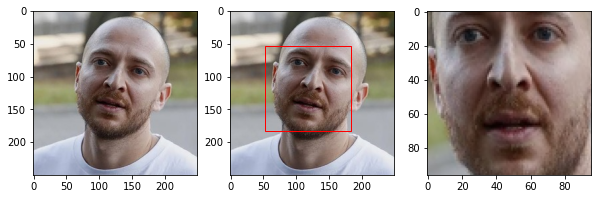

In [10]:
show_original_and_aligned(70)

In [11]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Генерация 128d векторного пространства

In [12]:
from progressbar import ProgressBar

num_images = metadata.shape[0]
progress = ProgressBar(num_images)
progress.start()

embedded = np.zeros((num_images, 128))

for i, m in enumerate(metadata):
    #print(m.image_path())    
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float64)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    progress.update(i)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


In [13]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

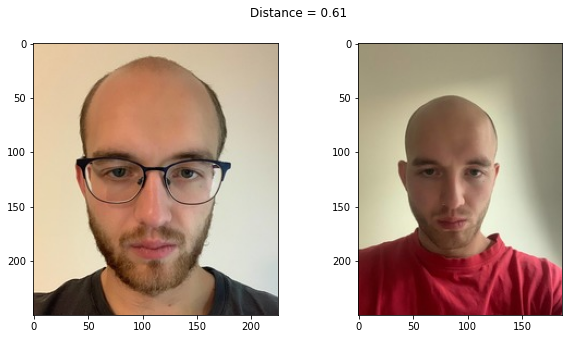

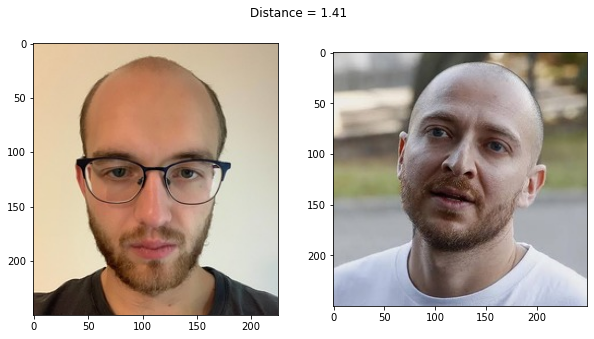

In [14]:
show_pair(71,72)
show_pair(71,70)

# Выбор лучшего порогового значения для верификации (сравнение 1 к 1) (Distance Treshold)

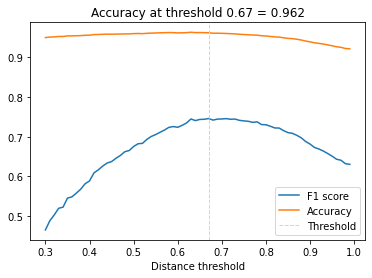

In [15]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

## Распределение расстояний между положительными и отрицательными парами

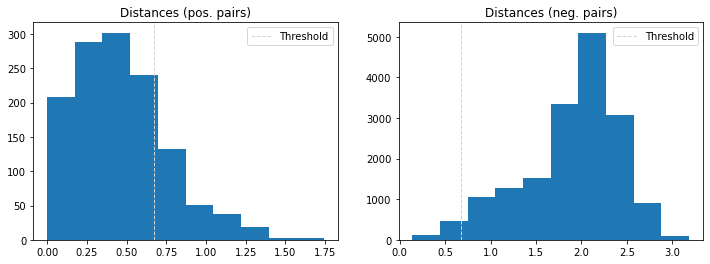

In [16]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# Распознованиt лиц  с KNN/SVM на основе полученного векторного пространства с помощью модели NN4 Small .

50:50 train&test split

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

test_idx = np.arange(metadata.shape[0]) % 2 != 0
train_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = knn.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9117647058823529, SVM accuracy = 0.9117647058823529


In [18]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction = knn.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(metadata[test_idx][idx].image_path())
        example_prediction = knn.predict([embedded[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}');        

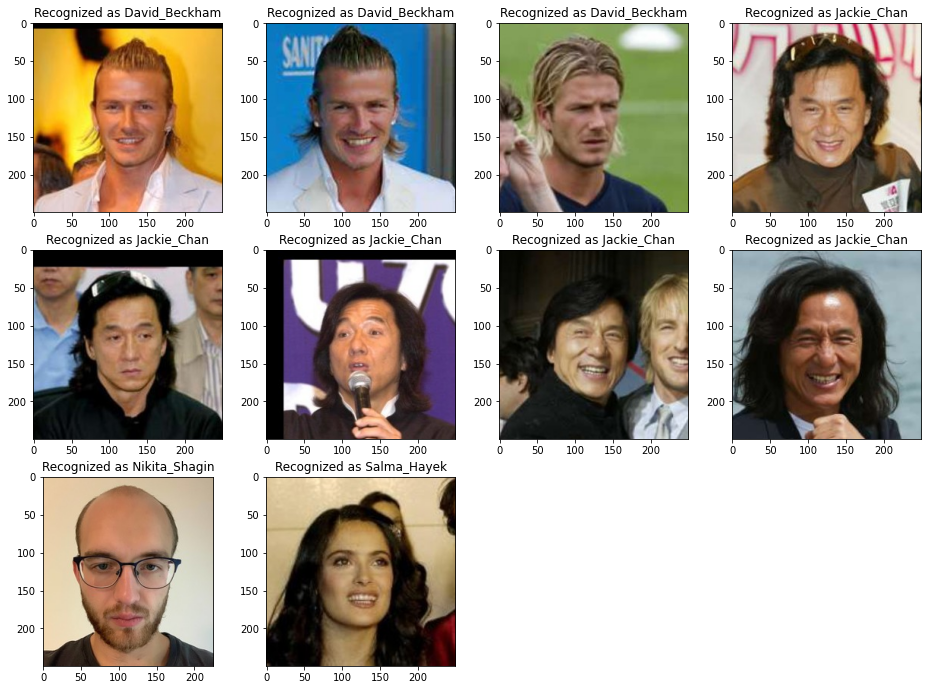

In [19]:
show_predictions(range(27,37))

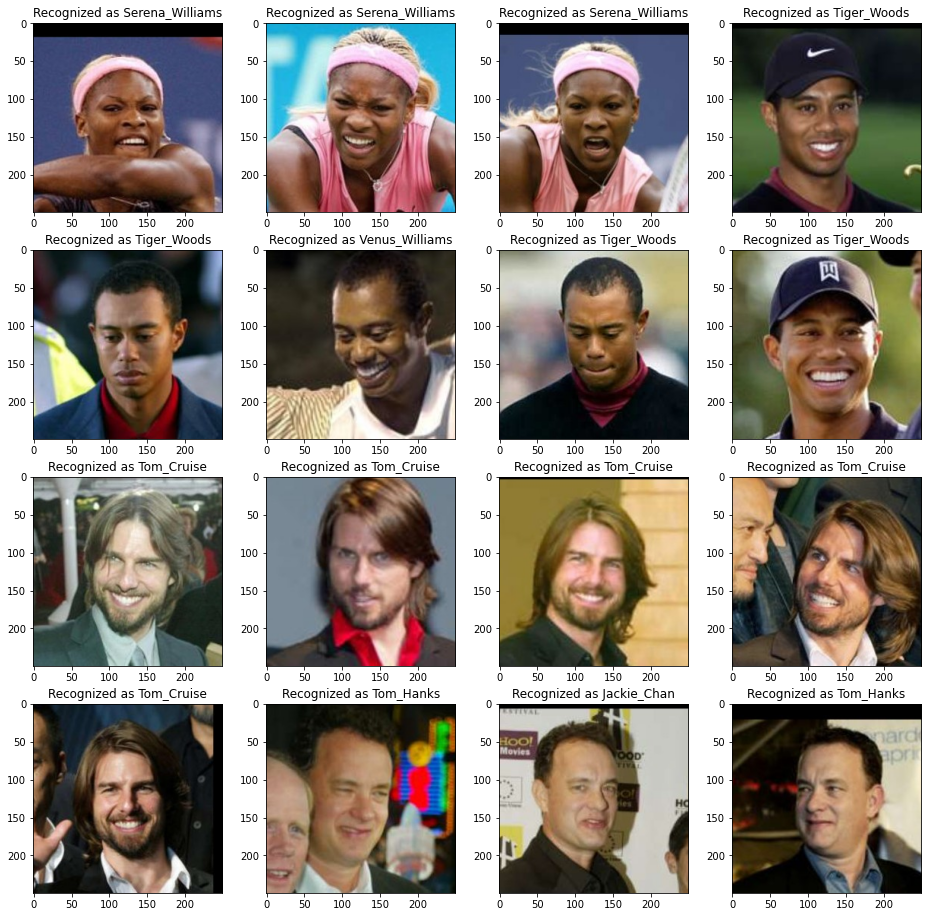

In [20]:
show_predictions(range(45,65))

## Неправильно классифицированные изображения

[1, 10, 18, 50, 59, 67]


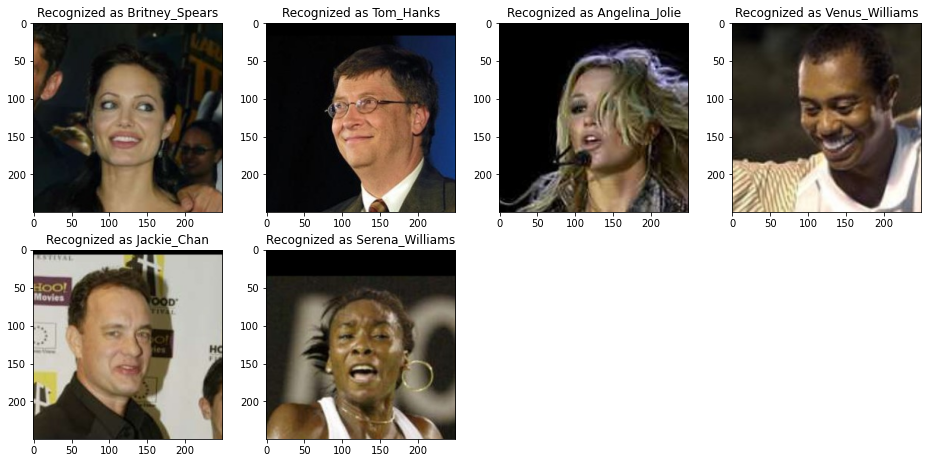

In [21]:
error_pairs = []

for i, item in enumerate(y_pred_knn):
    if item != y_test[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)


# Визуализация датасета

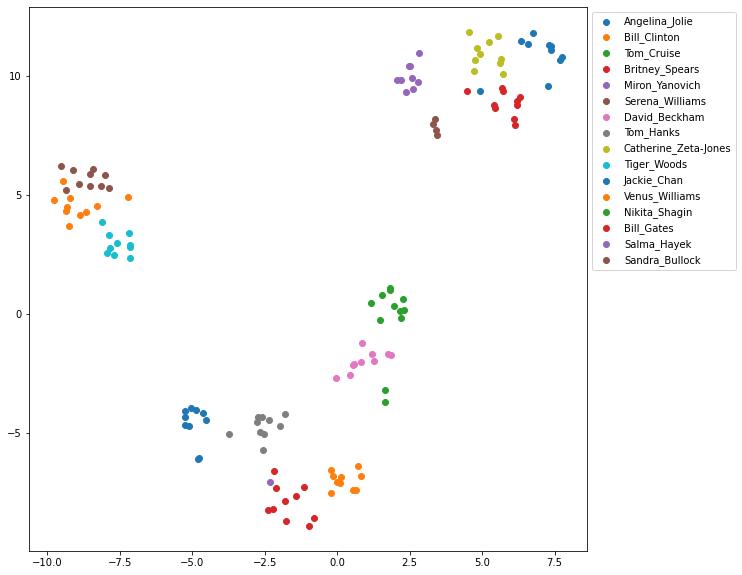

In [22]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));